# **Waze Churn Prediction Using Logistic Regression**
by Michelle Aguiar

**Executive Summary**

This case study explores user churn prediction for the Waze app using logistic regression. Understanding which user behaviors are linked to churn is vital to improve retention and support long-term growth. Logistic regression was chosen for its interpretability and as a baseline model for identifying drivers of churn.

Key usage features such as number of drives, navigation behavior, distance driven, and engagement frequency were analyzed. Feature engineering, outlier treatment, and multicollinearity checks were applied to improve data quality and model performance.

This project demonstrates the application of core data science skills:
* Real-world data preparation and cleaning
* Behavioral feature engineering
* Multicollinearity diagnostics
* Logistic regression modeling
* Model evaluation with classification metrics
* Translation of data signals into business insights

# **Imports and data loading**

The following packages were used for data analysis, visualization, and model development:

In [1]:
# Packages for numerics + dataframes
import pandas as pd
import numpy as np

# Packages for visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Packages for Logistic Regression & Confusion Matrix
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, precision_score, \
recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression

The dataset is loaded into a pandas DataFrame:

In [2]:
# Load the dataset by running this cell

df = pd.read_csv('waze_dataset.csv')

To understand the dataset structure:

In [3]:
# Review dataset dimensions
df.shape

(14999, 13)

**Dataset dimensions:**

* 14,999 rows
* 13 columns

Each row represents a unique user, and columns track their driving behavior and app engagement over a 30-day period. The `label` column serves as the target variable, identifying whether the user was retained or churned.

# **Exploratory Data Analysis (EDA)**

A preliminary analysis was conducted to understand the dataset's structure, identify missing values, and flag any potential outliers or data quality issues.

**Key observations:**
* The dataset includes 14,999 user records.
* The `label` column, which indicates churn status, is missing for 700 users (~4.7% of the data).
* A moderate class imbalance exists: ~82% of users are labeled as retained, while ~18% are labeled as churned.
* Several behavioral features such as `sessions`, `drives`, and `duration_minutes_drives` contain extreme values, suggesting the need for outlier treatment.

In [4]:
# Check dataset structure and missing values
print(df.shape)

df.info()

(14999, 13)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       14999 non-null  int64  
 1   label                    14299 non-null  object 
 2   sessions                 14999 non-null  int64  
 3   drives                   14999 non-null  int64  
 4   total_sessions           14999 non-null  float64
 5   n_days_after_onboarding  14999 non-null  int64  
 6   total_navigations_fav1   14999 non-null  int64  
 7   total_navigations_fav2   14999 non-null  int64  
 8   driven_km_drives         14999 non-null  float64
 9   duration_minutes_drives  14999 non-null  float64
 10  activity_days            14999 non-null  int64  
 11  driving_days             14999 non-null  int64  
 12  device                   14999 non-null  object 
dtypes: float64(3), int64(8), object(2)
memory usage: 1.5+ MB


In [5]:
df.head()

,ID,label,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,device
0,0,retained,283,226,296.748273,2276,208,0,2628.845068,1985.775061,28,19,Android
1,1,retained,133,107,326.896596,1225,19,64,13715.920550,3160.472914,13,11,iPhone
2,2,retained,114,95,135.522926,2651,0,0,3059.148818,1610.735904,14,8,Android
3,3,retained,49,40,67.589221,15,322,7,913.591123,587.196542,7,3,iPhone
4,4,retained,84,68,168.247020,1562,166,5,3950.202008,1219.555924,27,18,Android


Since the `ID` column is only a unique identifier and does not contain analytical value, it was removed:

In [6]:
#removed the ID column since it is not need for the analysis.
df = df.drop('ID', axis=1)

In [7]:
#checked the distribution of the target variable 
df['label'].value_counts(normalize=True)

retained    0.822645
churned     0.177355
Name: label, dtype: float64

Summary statistics across all variables helped identify variables with extreme values:

In [8]:
#evaluate key statistics
df.describe()

,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,80.633776,67.281152,189.964447,1749.837789,121.605974,29.672512,4039.340921,1860.976012,15.537102,12.179879
std,80.699065,65.913872,136.405128,1008.513876,148.121544,45.394651,2502.149334,1446.702288,9.004655,7.824036
min,0.000000,0.000000,0.220211,4.000000,0.000000,0.000000,60.441250,18.282082,0.000000,0.000000
25%,23.000000,20.000000,90.661156,878.000000,9.000000,0.000000,2212.600607,835.996260,8.000000,5.000000
50%,56.000000,48.000000,159.568115,1741.000000,71.000000,9.000000,3493.858085,1478.249859,16.000000,12.000000
75%,112.000000,93.000000,254.192341,2623.500000,178.000000,43.000000,5289.861262,2464.362632,23.000000,19.000000
max,743.000000,596.000000,1216.154633,3500.000000,1236.000000,415.000000,21183.401890,15851.727160,31.000000,30.000000


This confirms the presence of skewed features. For example, while the median number of sessions is 56, the maximum reaches 743. Similar skew appears in distance driven and duration of driving sessions, highlighting the need for outlier imputation before modeling.

## **Further Features**

To improve model performance and behavioral segmentation, two new features were engineered based on driving frequency and intensity:

### **Average Distance per Active Driving Day**

This feature measures user driving intensity by dividing the total kilometers driven by the number of active driving days. It helps distinguish between casual users and highly engaged (or professional) drivers.

In [9]:
# 1. Create `km_per_driving_day` column
df['km_per_driving_day'] = df['driven_km_drives'] / df['driving_days']

# 2. Call `describe()` on the new column
df['km_per_driving_day'].describe()

count    1.499900e+04
mean              inf
std               NaN
min      3.022063e+00
25%      1.672804e+02
50%      3.231459e+02
75%      7.579257e+02
max               inf
Name: km_per_driving_day, dtype: float64

The initial result showed infinite values for users with 0 driving days, creating division by zero. This was corrected by replacing infinities with 0:

In [10]:
# Convert infinite values to zero
df.loc[df['km_per_driving_day']==np.inf, 'km_per_driving_day'] = 0

# Confirm that it worked
df['km_per_driving_day'].describe()

count    14999.000000
mean       578.963113
std       1030.094384
min          0.000000
25%        136.238895
50%        272.889272
75%        558.686918
max      15420.234110
Name: km_per_driving_day, dtype: float64

This cleaned metric shows high variability across users. Users averaging thousands of kilometers per day are likely outliers or commercial users, supporting the value of this variable as a churn predictor.

### **Binary Flag for High-Volume Users**

This binary variable identifies potential commercial or habitual users, defined as those who:

* Completed at least 60 drives, and
* Drove on 15 or more days during the period.

In [11]:
# Create `professional_driver` column
df['professional_driver'] = np.where((df['drives'] >= 60) & (df['driving_days'] >= 15), 1, 0)

To inspect the relationship between this feature and churn:

In [12]:
# Check count of professionals and non-professionals
print(df['professional_driver'].value_counts())

# Check in-class churn rate
df.groupby(['professional_driver'])['label'].value_counts(normalize=True)

0    12405
1     2594
Name: professional_driver, dtype: int64


professional_driver  label   
0                    retained    0.801202
                     churned     0.198798
1                    retained    0.924437
                     churned     0.075563
Name: label, dtype: float64

This strong negative relationship with churn confirms that high-frequency users are significantly more likely to stay, reinforcing the strategic value of this segment for retention planning.

## **Data Cleaning and Preprocessing**

Before modeling, several data preparation steps were completed to improve data quality and ensure assumptions for logistic regression were satisfied. These included handling missing values, treating outliers, and encoding categorical variables.

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   label                    14299 non-null  object 
 1   sessions                 14999 non-null  int64  
 2   drives                   14999 non-null  int64  
 3   total_sessions           14999 non-null  float64
 4   n_days_after_onboarding  14999 non-null  int64  
 5   total_navigations_fav1   14999 non-null  int64  
 6   total_navigations_fav2   14999 non-null  int64  
 7   driven_km_drives         14999 non-null  float64
 8   duration_minutes_drives  14999 non-null  float64
 9   activity_days            14999 non-null  int64  
 10  driving_days             14999 non-null  int64  
 11  device                   14999 non-null  object 
 12  km_per_driving_day       14999 non-null  float64
 13  professional_driver      14999 non-null  int64  
dtypes: float64(4), int64(8

### **Handling Missing Labels**
The target variable `label` (retained vs. churned) was missing for 700 users (≈4.7%). Since there was no evidence of non-random missingness, these rows were removed to avoid introducing bias into the model.

In [14]:
# Drop rows with missing data in `label` column
df = df.dropna(subset=['label'])

### **Outlier Treatment**

Several numeric columns contained extreme outliers that could skew the logistic regression model. To reduce their influence while preserving the structure of the data, the 95th percentile was used as a cap for the following columns:
* `sessions`
* `drives`
* `total_sessions`
* `total_navigations_fav1`
* `total_navigations_fav2`
* `driven_km_drives`
* `duration_minutes_drives`

In [15]:
# Impute outliers by capping at 95th percentile
for column in ['sessions', 'drives', 'total_sessions', 'total_navigations_fav1',
               'total_navigations_fav2', 'driven_km_drives', 'duration_minutes_drives']:
    threshold = df[column].quantile(0.95)
    df.loc[df[column] > threshold, column] = threshold

Post-treatment, distributions remained intact but were less skewed:

In [16]:
# Re-check statistics after imputation
df.describe()

,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,km_per_driving_day,professional_driver
count,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000
mean,76.539688,63.964683,183.717304,1751.822505,114.562767,27.187216,3944.558631,1792.911210,15.544653,12.182530,581.942399,0.173998
std,67.243178,55.127927,118.720520,1008.663834,124.378550,36.715302,2218.358258,1224.329759,9.016088,7.833835,1038.254509,0.379121
min,0.000000,0.000000,0.220211,4.000000,0.000000,0.000000,60.441250,18.282082,0.000000,0.000000,0.000000,0.000000
25%,23.000000,20.000000,90.457733,878.500000,10.000000,0.000000,2217.319909,840.181344,8.000000,5.000000,136.168003,0.000000
50%,56.000000,48.000000,158.718571,1749.000000,71.000000,9.000000,3496.545617,1479.394387,16.000000,12.000000,273.301012,0.000000
75%,111.000000,93.000000,253.540450,2627.500000,178.000000,43.000000,5299.972162,2466.928876,23.000000,19.000000,558.018761,0.000000
max,243.000000,200.000000,455.439492,3500.000000,422.000000,124.000000,8898.716275,4668.180092,31.000000,30.000000,15420.234110,1.000000


This step improved numerical stability and helped prevent distorted coefficient estimates during model training.

### **Target Variable Encoding**

To prepare for binary classification, the target variable was encoded numerically:

* `retained` → 0
* `churned` → 1

In [17]:
# Create binary `label2` column
df['label2'] = np.where(df['label']=='churned', 1, 0)
df[['label', 'label2']].tail()

,label,label2
14994,retained,0
14995,retained,0
14996,retained,0
14997,churned,1
14998,retained,0


## **Multicollinearity Check**

Multicollinearity occurs when two or more predictors are highly correlated, which can distort model interpretation by inflating coefficient variance. To ensure model validity and interpretability, a correlation matrix was computed and visualized using a heatmap.

#### **Correlation Matrix**

Pearson correlation coefficients were calculated for all numerical predictors:

In [18]:
# Generate a correlation matrix
df.corr(method='pearson')

,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,km_per_driving_day,professional_driver,label2
sessions,1.000000,0.996942,0.597189,0.007101,0.001858,0.008536,0.002996,-0.004545,0.025113,0.020294,-0.011569,0.443654,0.034911
drives,0.996942,1.000000,0.595285,0.006940,0.001058,0.009505,0.003445,-0.003889,0.024357,0.019608,-0.010989,0.444425,0.035865
total_sessions,0.597189,0.595285,1.000000,0.006596,0.000187,0.010371,0.001016,-0.000338,0.015755,0.012953,-0.016167,0.254433,0.024568
n_days_after_onboarding,0.007101,0.006940,0.006596,1.000000,-0.002450,-0.004968,-0.004652,-0.010167,-0.009418,-0.007321,0.011764,0.003770,-0.129263
total_navigations_fav1,0.001858,0.001058,0.000187,-0.002450,1.000000,0.002866,-0.007368,0.005646,0.010902,0.010419,-0.000197,-0.000224,0.052322
total_navigations_fav2,0.008536,0.009505,0.010371,-0.004968,0.002866,1.000000,0.003559,-0.003009,-0.004425,0.002000,0.006751,0.007126,0.015032
driven_km_drives,0.002996,0.003445,0.001016,-0.004652,-0.007368,0.003559,1.000000,0.690515,-0.007441,-0.009549,0.344811,-0.000904,0.019767
duration_minutes_drives,-0.004545,-0.003889,-0.000338,-0.010167,0.005646,-0.003009,0.690515,1.000000,-0.007895,-0.009425,0.239627,-0.012128,0.040407
activity_days,0.025113,0.024357,0.015755,-0.009418,0.010902,-0.004425,-0.007441,-0.007895,1.000000,0.947687,-0.397433,0.453825,-0.303851
driving_days,0.020294,0.019608,0.012953,-0.007321,0.010419,0.002000,-0.009549,-0.009425,0.947687,1.000000,-0.407917,0.469776,-0.294259


The matrix revealed several strong correlations:

* `sessions` and `drives`: r = 0.997
* `activity_days` and `driving_days`: r = 0.948

These near-linear relationships indicate redundancy.

### **Heatmap Visualization**

A heatmap was plotted to visually inspect variable relationships:

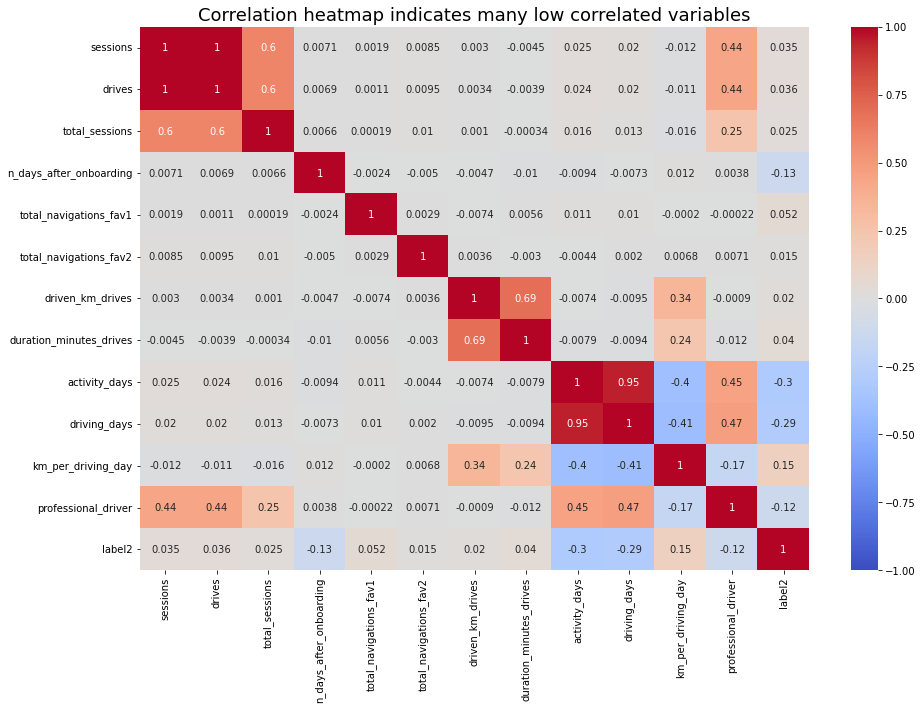

In [19]:
# Plot correlation heatmap
plt.figure(figsize=(15,10))
sns.heatmap(df.corr(method='pearson'), vmin=-1, vmax=1, annot=True, cmap='coolwarm')
plt.title('Correlation heatmap indicates many low correlated variables',
          fontsize=18)
plt.show();

The heatmap confirmed that most features had low to moderate correlation, but `sessions` and `driving_days` were clear exceptions. Their high collinearity with other variables posed a risk to coefficient stability.

### **Final Feature Decisions**

To reduce multicollinearity without sacrificing interpretive power:

* `sessions` was removed (kept `drives` instead, which has slightly stronger correlation with churn)
* `driving_days` was removed (kept `activity_days`, which better reflects consistency of engagement)

This refinement preserved behavioral diversity in the model while improving statistical reliability.

## **Encoding Categorical Variables**

Logistic regression models require numerical inputs. In this dataset, device was the only categorical variable, identifying whether a user accessed Waze via an Android or iPhone device.

To include this variable in the model, a simple binary encoding was applied:

* Android → 0
* iPhone → 1

This preserves the variable’s information while avoiding overfitting from unnecessary dummy variables.

In [20]:
# Create new `device2` variable
df['device2'] = np.where(df['device']=='Android', 0, 1)
df[['device', 'device2']].tail()

,device,device2
14994,iPhone,1
14995,Android,0
14996,iPhone,1
14997,iPhone,1
14998,iPhone,1


As device only includes two categories and its business meaning is straightforward, this encoding provides an efficient and interpretable transformation.

## **Model Building**

With the data cleaned, encoded, and checked for multicollinearity, the logistic regression model was constructed to predict churn based on user behavior.

### **Feature Selection**

Based on previous steps, the following columns were excluded from modeling:

* `label` and `label2`: Target variables
* `device`: Original categorical variable (replaced by `device2`)
* `sessions`: Dropped due to high collinearity with `drives`
* `driving_days`: Dropped due to high collinearity with `activity_days`

The final list of **independent variables** included:
* `drives`
* `total_sessions`
* `n_days_after_onboarding`
* `total_navigations_fav1`
* `total_navigations_fav2`
* `driven_km_drives`
* `duration_minutes_drives`
* `activity_days`
* `km_per_driving_day`
* `professional_driver`
* `device2`

The **dependent variable** was `label2`, with values:

* 0 = retained
* 1 = churned

In [21]:
# Isolate predictor variables
X = df.drop(columns = ['label', 'label2', 'device', 'sessions', 'driving_days'])

In [22]:
# Isolate target variable
y = df['label2']

### **Train-Test Split**

The dataset was split into 80% training and 20% testing. To preserve class balance across splits, stratified sampling was used:

In [23]:
# Perform the train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

Inspect the training set:

In [24]:
# Use .head() to preview X_train
X_train.head()

,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,km_per_driving_day,professional_driver,device2
152,108,186.192746,3116,243,124,8898.716275,4668.180092,24,612.305861,1,1
11899,2,3.487590,794,114,18,3286.545691,1780.902733,5,3286.545691,0,1
10937,139,347.106403,331,4,7,7400.838975,2349.305267,15,616.736581,0,0
669,108,455.439492,2320,11,4,6566.424830,4558.459870,18,410.401552,1,1
8406,10,89.475821,2478,135,0,1271.248661,938.711572,27,74.779333,0,1


### **Model Training**

A logistic regression model was instantiated using `penalty='none'` to disable regularization, since feature scaling was not applied:

In [25]:
# Instantiate and train logistic regression model

model = LogisticRegression(penalty='none', max_iter=400)

model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=400,
                   multi_class='auto', n_jobs=None, penalty='none',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Model coefficients were extracted for interpretation:

In [26]:
# View model coefficients
pd.Series(model.coef_[0], index=X.columns)

drives                     0.001913
total_sessions             0.000327
n_days_after_onboarding   -0.000406
total_navigations_fav1     0.001232
total_navigations_fav2     0.000931
driven_km_drives          -0.000015
duration_minutes_drives    0.000109
activity_days             -0.106032
km_per_driving_day         0.000018
professional_driver       -0.001529
device2                   -0.001041
dtype: float64

Intercept:

In [27]:
# View model intercept
model.intercept_

array([-0.00170675])

Coefficients represent changes in the log-odds of churn per unit increase in each feature. For example, a negative coefficient on `activity_days` suggests higher activity correlates with lower churn probability.

## **Assumption Validation: Logit Linearity**

One key assumption of logistic regression is that there is a linear relationship between each continuous predictor and the log-odds (logit) of the outcome. This ensures that increases in predictors correspond consistently to increases or decreases in the probability of churn on a log-odds scale.

In [28]:
# Get the predicted probabilities of the training data
training_probabilities = model.predict_proba(X_train)
training_probabilities

array([[0.93963483, 0.06036517],
       [0.61967304, 0.38032696],
       [0.76463181, 0.23536819],
       ...,
       [0.91909641, 0.08090359],
       [0.85092112, 0.14907888],
       [0.93516293, 0.06483707]])

To assess the logit relationship, the probabilities were converted into log-odds.

This transformation was added as a new column:

In [29]:
# Copy the `X_train` dataframe and assign to `logit_data`
logit_data = X_train.copy()

# Create a `logit` column using the predicted probabilities
logit_data['logit'] = [np.log(prob[1] / prob[0]) for prob in training_probabilities]

### **Visual Check: Logit vs. Predictor Variable**

To visually confirm linearity, a regression plot was created for one key continuous variable, activity_days, against the log-odds:

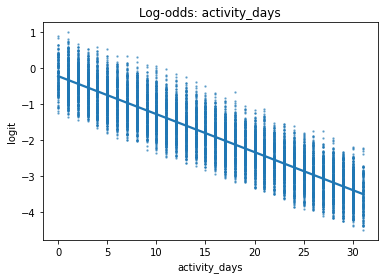

In [30]:
# Plot regplot of `activity_days` log-odds
sns.regplot(x='activity_days', y='logit', data=logit_data, scatter_kws={'s': 2, 'alpha': 0.5})
plt.title('Log-odds: activity_days');

The trend line showed an approximately linear relationship, confirming that `activity_days` satisfies the logit linearity assumption. While minor deviations existed, they were within reasonable bounds for a behavioral dataset.

## **Results and Evaluation**

After training, the logistic regression model was evaluated on the test set to assess its real-world performance. Both standard metrics and diagnostic visuals were used to analyze predictive quality.

In [31]:
# Generate predictions on X_test
y_preds = model.predict(X_test)

In [32]:
# Score the model (accuracy) on the test data
model.score(X_test, y_test)

0.8237762237762237

The model achieved an accuracy of 82.4%, reflecting strong baseline performance. However, due to class imbalance (~82% retained vs. ~18% churned), accuracy alone is insufficient to evaluate effectiveness.

### **Confusion Matrix**

In [33]:
# Generate confusion matrix
cm = confusion_matrix(y_test, y_preds)

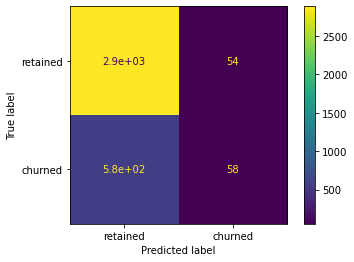

In [34]:
# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                              display_labels=['retained', 'churned'],
                              )
disp.plot();

The confusion matrix showed that the model predicted retained users reliably but struggled to correctly identify churners. This is a typical tradeoff in imbalanced classification settings.

### **Precision and Recall**

Manual calculations:

In [35]:
# Calculate precision manually
precision = cm[1,1] / (cm[0, 1] + cm[1, 1])
precision

0.5178571428571429

In [36]:
# Calculate recall manually
recall = cm[1,1] / (cm[1, 0] + cm[1, 1])
recall

0.0914826498422713

The model achieved ~52% precision but only ~9% recall on churned users. In other words, when it predicted churn, it was right half the time, but it failed to identify 91% of actual churners.

### **Classification Report**

In [37]:
# Create a classification report
target_labels = ['retained', 'churned']
print(classification_report(y_test, y_preds, target_names=target_labels))

              precision    recall  f1-score   support

    retained       0.83      0.98      0.90      2941
     churned       0.52      0.09      0.16       634

    accuracy                           0.82      3575
   macro avg       0.68      0.54      0.53      3575
weighted avg       0.78      0.82      0.77      3575



While the model performs well on the dominant class (retained), the low recall for churned users highlights a key limitation. The model misses most at-risk users, which reduces its strategic value for retention planning.

If deployed in production, the model would fail to trigger interventions for most churn-prone users. While its precision may be useful for confidently flagging some churners, its low recall would severely limit ROI on retention campaigns.

## **Conclusion and Recommendations**

This logistic regression analysis aimed to identify behavioral signals of churn in Waze’s user base and build an interpretable baseline model. While the model delivered high accuracy and clear behavioral insights, it also exposed important limitations regarding churn detection.

### **Key Findings**
* **Strongest predictor of retention:** The binary feature `professional_driver` was the most influential. High-frequency, high-engagement users had significantly lower churn rates, confirming that daily utility drives stickiness.
* **Weak predictive signals:** Variables such as `device2` (Android vs. iPhone) and `total_navigations_fav2` showed minimal influence on churn, suggesting these behaviors are less tied to user loyalty.
* **Model performance:** The model achieved strong overall accuracy (82%) and precision for churners (52%), but recall remained very low (~9%). This suggests the model frequently fails to flag true churners, reducing its reliability for proactive retention strategy.

### **Recommendations**
1. **Treat this model as a diagnostic tool, not a standalone solution.** It can support user segmentation and cohort analysis, but should not be used alone to trigger churn interventions.
2. **Address class imbalance.** Techniques such as SMOTE (Synthetic Minority Oversampling Technique) or reweighting the loss function should be applied to improve recall for churned users.
3. **Explore more complex models.** Tree-based models like Random Forests or XGBoost may capture nonlinear behavior patterns and interactions missed by logistic regression.
4. **Enrich the feature set.** Incorporating additional variables—such as app feedback, session timestamps, referral source, or historical engagement trends—could improve predictive power.
5. **Consider user segmentation.** Cluster analysis could help identify distinct user personas (e.g., commuters vs. commercial drivers), enabling more personalized retention strategies.